# Práctica 6 - Modularidad e Identificación de Comunidades

## Objetivo
En esta práctica se propone implementar en una función para el cálculo de la modularidad de una red, y posteriormente implementar el algoritmo de Girvan-Newman para la partición de una red mediante la eliminación sucesiva de los enlaces de mayor betweenness.
## 1 Modularidad
### 1.1 Implementar una función que calcula la modularidad de una red no dirigida para una partición de los nodos propuesta. 
La función tendrá como argumentos de entrada:
- Un objeto Graph (Networkx)
- Un diccionario con la partición, e.g. { ‘node1’: c1, ‘node2’:c2, …}



In [136]:
#Imports
import networkx as nx
from itertools import product
from networkx.algorithms import community

import numpy as np
import matplotlib.pyplot as plt

Función que calcula la modularidad de una red ND para una particion de nodos.

In [137]:
def calcularModularidad(red, diccionario):
    Q = 0
    
    nx.set_edge_attributes(red, {e:1 for e in red.edges}, 'peso')
    
    A = nx.to_scipy_sparse_array(red).astype(float)

    out_degree = in_degree = dict(nx.degree(red))
    m = red.number_of_edges()
    nodos = list(red)
    
    for i, j in product(range(len(nodos)),range(len(nodos))):
        if (diccionario[nodos[i]] == diccionario[nodos[j]]):
             Q += np.sum(A[i,j] - (in_degree[nodos[i]]*out_degree[nodos[j]]/(2*m)))

    return Q / (2*m)

### 1.2 Comprobar el valor de la modularidad para los siguientes ejemplos:
##### 1 Ejemplo de Wikipedia 
Modularidad de la partición de colores = 0.4896


In [138]:
def definicionGrafo():
    "Creamos el grafo de la red de contactos propuesta"
    G=nx.Graph()
    G.add_edges_from([(1,2),(1,3),(3,2),(1,4),(4,5),(5,6),(6,7),(7,5),(4,8),(8,9),(9,10),(10,8)])
    
    "Diccionario de nodos:comunidad"
    nodes = list(G)
    diccionario = {}
    for elemento in nodes:
        if elemento <= 4:
            diccionario[elemento] = 1
        elif 5 <= elemento < 8:
            diccionario[elemento] = 2
        else:
            diccionario[elemento] = 3
            
    return G,diccionario

La modularidad de la partición de colores es 0.4895833333333333


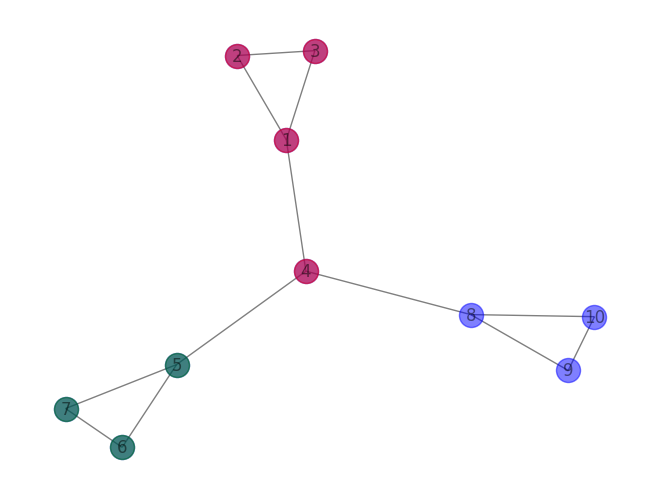

In [139]:
red, nodos = definicionGrafo()

pos=nx.fruchterman_reingold_layout(red,k=0.25)
nx.draw(red,pos,with_labels=True,node_color='b',alpha=0.5)
nx.draw_networkx_nodes(red,pos,nodelist=[5,6,7],node_color='g', alpha=0.5)
nx.draw_networkx_nodes(red,pos,nodelist=[1,2,3,4],node_color='r', alpha=0.5)

print("La modularidad de la partición de colores es", calcularModularidad(red,nodos))

##### 2 Ejemplo de clase #####

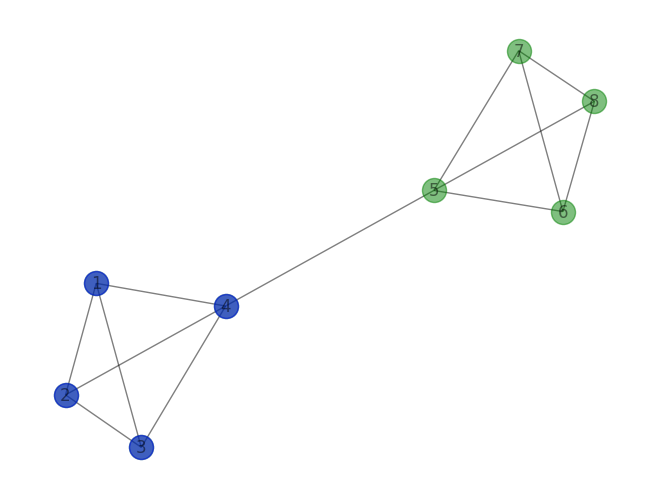

In [140]:
def definicionGrafo2():
    G = nx.Graph()
    G.add_edges_from([(1,2),(1,3),(1,4),(2,3),(2,4),(3,4),(4,5),(5,6),(5,7),(5,8),(6,7),(6,8),(7,8)])
    pos = nx.fruchterman_reingold_layout(G,k=0.25)
    nx.draw(G, pos, with_labels=True, node_color='g', alpha=0.5)
    nx.draw_networkx_nodes(G, pos, nodelist=[1,2,3,4], node_color='b', alpha=0.5)

    return G

red2 = definicionGrafo2()

1. Para una partición correspondiente a toda la red (modularidad = 0)

In [141]:
nodos = list(red2)
diccionario = {}
for e in nodos:
    diccionario[e] = 1

print("La modularidad es:", round(calcularModularidad(red2, diccionario))) 

La modularidad es: 0


2. Para una partición correspondiente a cada nodo (modularidad = -0.1272)

In [142]:
diccionario2 = {}
num = 1
for e in nodos:
    diccionario2[e] = num
    num += 1   

print("La modularidad es:", round(calcularModularidad(red2, diccionario2),4))

La modularidad es: -0.1272


3. Para la partición de colores (modularidad = 0.4231)

In [143]:
diccionario3 = {}
for e in nodos:
    if e <= 4:
        diccionario3[e] = 1
    else:
        diccionario3[e] = 2

print("La modularidad es:", round(calcularModularidad(red2, diccionario3),4))

La modularidad es: 0.4231


## 2 Detección de comunidades basada en la eliminación de enlaces
### 2.1 Implementar la detección de comunidades basada en la eliminación recursiva de enlaces “shortest-path betweenness” propuesta por Newman y Girvan

In [144]:
# Elimina bordes
# Calcula el edgebetweenness
def eliminarBordes(G):
    compConectados = nx.number_connected_components(G)
    ncomp = compConectados
    while ncomp <= compConectados:
        centralidadIn = nx.edge_betweenness_centrality(G, weight='peso') #edgebetweenness
        
        #Borde con mayor centralidad
        maximo = max(centralidadIn.values())
        
        for j, i in centralidadIn.items():
            if float(i) == maximo:
                G.remove_edge(j[0],j[1])    
        ncomp = nx.number_connected_components(G)   


# Calcula la modularidad de la particion
def modularidadGirvanNewman(G, diccionario, peso):
    nuevaMatriz = nx.to_numpy_array(G)
    diccionarioAux = {}
    diccionarioAux = actualizarDicc(nuevaMatriz, G.nodes())
    
    #Calculamos modularidad
    componentes = nx.connected_components(G)    #Lista de componentes
    Q = 0    #modularidad de la particion dada
    for elemento in componentes:
        bordesSinComunidad = 0    
        bordesAl = 0 
        for i in elemento:
            bordesSinComunidad += diccionarioAux[i]
            bordesAl += diccionario[i]     
        Q += (float(bordesSinComunidad) - float(bordesAl*bordesAl)/float(2*peso))
    Q = Q/float(2*peso)
    return Q

#Actualiza el diccionario de nodos:comunidad
def actualizarDicc(A, nodos):
    B = np.sum(A, axis=1)
    diccionario = {}
    i = 0
    for idNodo in list(nodos):
        diccionario[idNodo] = B[i]
        i += 1
    return diccionario


# Ejecuta el algoritmo de GirvanNewman y encuentra la mejor partición, aquella con mayor valor de modularidad
def algoritmoNewmanGirvan(G, diccionario, peso):
    dicModularidad = {}
    mejorParticion = 0
    maximaMoludaridad = 0
    
    #Variable para encontrar la mejor particion (mayor modularidad)
    maxModularidad = 0.0
    Q = 0.0
    while True:    
        eliminarBordes(G)
        Q = modularidadGirvanNewman(G, diccionario, peso);
        dicModularidad[nx.number_connected_components(G)] = Q
        if G.number_of_edges() == 0:
            break
    
    for clave,valor in dicModularidad.items():
        if valor > maxModularidad:
            maxModularidad = valor
            mejorParticion = clave
    
    return dicModularidad,mejorParticion

### 2.2 Comprobar el algoritmo de detección de comunidades anterior con la red “Zachary’s karate club” que se encuentra dentro de la librería de Networkx.


In [145]:
G = nx.karate_club_graph()
n = G.number_of_nodes()    #|V|
A = nx.to_numpy_array(G)   #adjacenct matrix

#Peso de los bordes
peso = 0.0    
for i in range(0,n):
    for j in range(0,n):
        peso += A[i,j]
peso = peso/2.0

#Grado de cada nodo
diccionario = actualizarDicc(A, G.nodes())

#Algoritmo
diccModularidad, mejorParticion = algoritmoNewmanGirvan(G, diccionario, peso)

print("La particion con mayor valor de modularidad tiene", mejorParticion,"comunidades y una modularidad de:", dicModularidad.get(mejorParticion) )

La particion con mayor valor de modularidad tiene 5 comunidades y una modularidad de: 0.38497217068645645


Mostrar un gráfico con la modularidad vs el número de divisiones

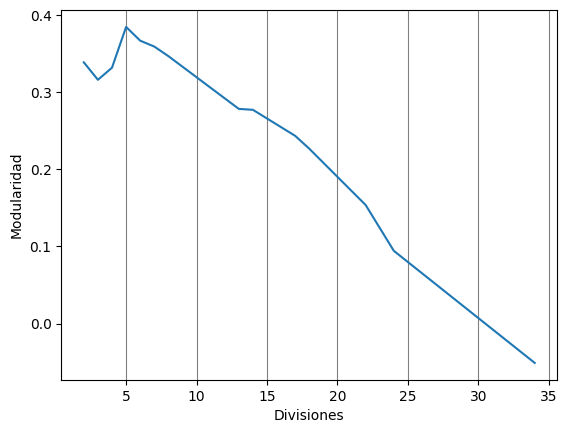

In [146]:
divisiones = []
modularidad = []

for key, value in diccModularidad.items():
    divisiones.append(key)
    modularidad.append(value)

fig, ax = plt.subplots()
ax.set_xlabel('Divisiones')
ax.set_ylabel('Modularidad')
ax.plot(divisiones, modularidad)
ax.grid(axis = 'x', color = 'gray')
plt.show()